In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
df_bs = pd.read_csv('/content/drive/MyDrive/DS Capstone/data/sp500/Balance_Sheet_quarterly.csv')

## Final preprocessor function

In [84]:
def feature_selection_BS(df_balance_sheet, corr_threshold=0.7):
  # Drop those that are sums of other features
  to_drop_1 = ['totalAssets', 'intangibleAssets', 'earningAssets', 'otherCurrentAssets', 'totalLiab',
             'totalStockholderEquity', 'deferredLongTermLiab', 'otherCurrentLiab', 'otherLiab', 'otherAssets',
             'totalCurrentLiabilities', 'netDebt', 'shortLongTermDebtTotal', 'otherStockholderEquity',
             'totalCurrentAssets', 'netTangibleAssets', 'commonStockTotalEquity', 'preferredStockTotalEquity',
             'retainedEarningsTotalEquity', 'nonCurrentAssetsTotal', 'longTermDebtTotal',
             'nonCurrentLiabilitiesTotal', 'liabilitiesAndStockholdersEquity', 'cashAndShortTermInvestments',
             'propertyPlantAndEquipmentGross', 'propertyPlantAndEquipmentNet']
  try:
    df_balance_sheet_updated = df_balance_sheet.drop(columns=to_drop_1)
  except KeyError as e:
    print('Check dataframe columns:', e)

  # Drop those that are highly correlated to other features
  corr_matrix = df_balance_sheet_updated.corr()
  corr_matrix_abs = corr_matrix.abs()
  mat = np.array(corr_matrix_abs)
  corr_matrix_abs["counts"] = [np.sum(item > corr_threshold)-1 for item in mat]
  to_drop_2 = corr_matrix_abs[~corr_matrix_abs['counts'].between(0, 3)].index.to_list()
  try:
    df_balance_sheet_updated = df_balance_sheet_updated.drop(columns=to_drop_2)
  except KeyError as e:
    print('Check dataframe columns:', e)

  # Drop those that are irrelevant in nature
  to_drop_3 = ['capitalStock', 'shortLongTermDebt', 'totalPermanentEquity',
             'noncontrollingInterestInConsolidatedEntity', 
             'temporaryEquityRedeemableNoncontrollingInterests',
             'accumulatedOtherComprehensiveIncome', 'additionalPaidInCapital',
             'nonCurrrentAssetsOther', 'capitalLeaseObligations',
             'nonCurrentLiabilitiesOther', 'capitalSurpluse',
             'commonStockSharesOutstanding']
  try:
    df_balance_sheet_updated = df_balance_sheet_updated.drop(columns=to_drop_3)
  except KeyError as e:
    print('Check dataframe columns:', e)
  return df_balance_sheet_updated

In [86]:
# Print selected features
df_bs_updated = feature_selection_BS(df_bs)
df_bs_updated.columns.to_list()[4:]

['commonStock',
 'retainedEarnings',
 'goodWill',
 'cash',
 'currentDeferredRevenue',
 'shortTermDebt',
 'propertyPlantEquipment',
 'longTermInvestments',
 'shortTermInvestments',
 'netReceivables',
 'longTermDebt',
 'inventory',
 'accountsPayable',
 'treasuryStock',
 'warrants',
 'netWorkingCapital',
 'netInvestedCapital']

## Selection process

In [47]:
# Dropping those that are sums of other features
to_drop_1 = ['totalAssets', 'intangibleAssets', 'earningAssets', 'otherCurrentAssets', 'totalLiab',
             'totalStockholderEquity', 'deferredLongTermLiab', 'otherCurrentLiab', 'otherLiab', 'otherAssets',
             'totalCurrentLiabilities', 'netDebt', 'shortLongTermDebtTotal', 'otherStockholderEquity',
             'totalCurrentAssets', 'netTangibleAssets', 'commonStockTotalEquity', 'preferredStockTotalEquity',
             'retainedEarningsTotalEquity', 'nonCurrentAssetsTotal', 'longTermDebtTotal',
             'nonCurrentLiabilitiesTotal', 'liabilitiesAndStockholdersEquity', 'cashAndShortTermInvestments',
             'propertyPlantAndEquipmentGross', 'propertyPlantAndEquipmentNet']
df_bs.drop(columns=to_drop_1, inplace=True)

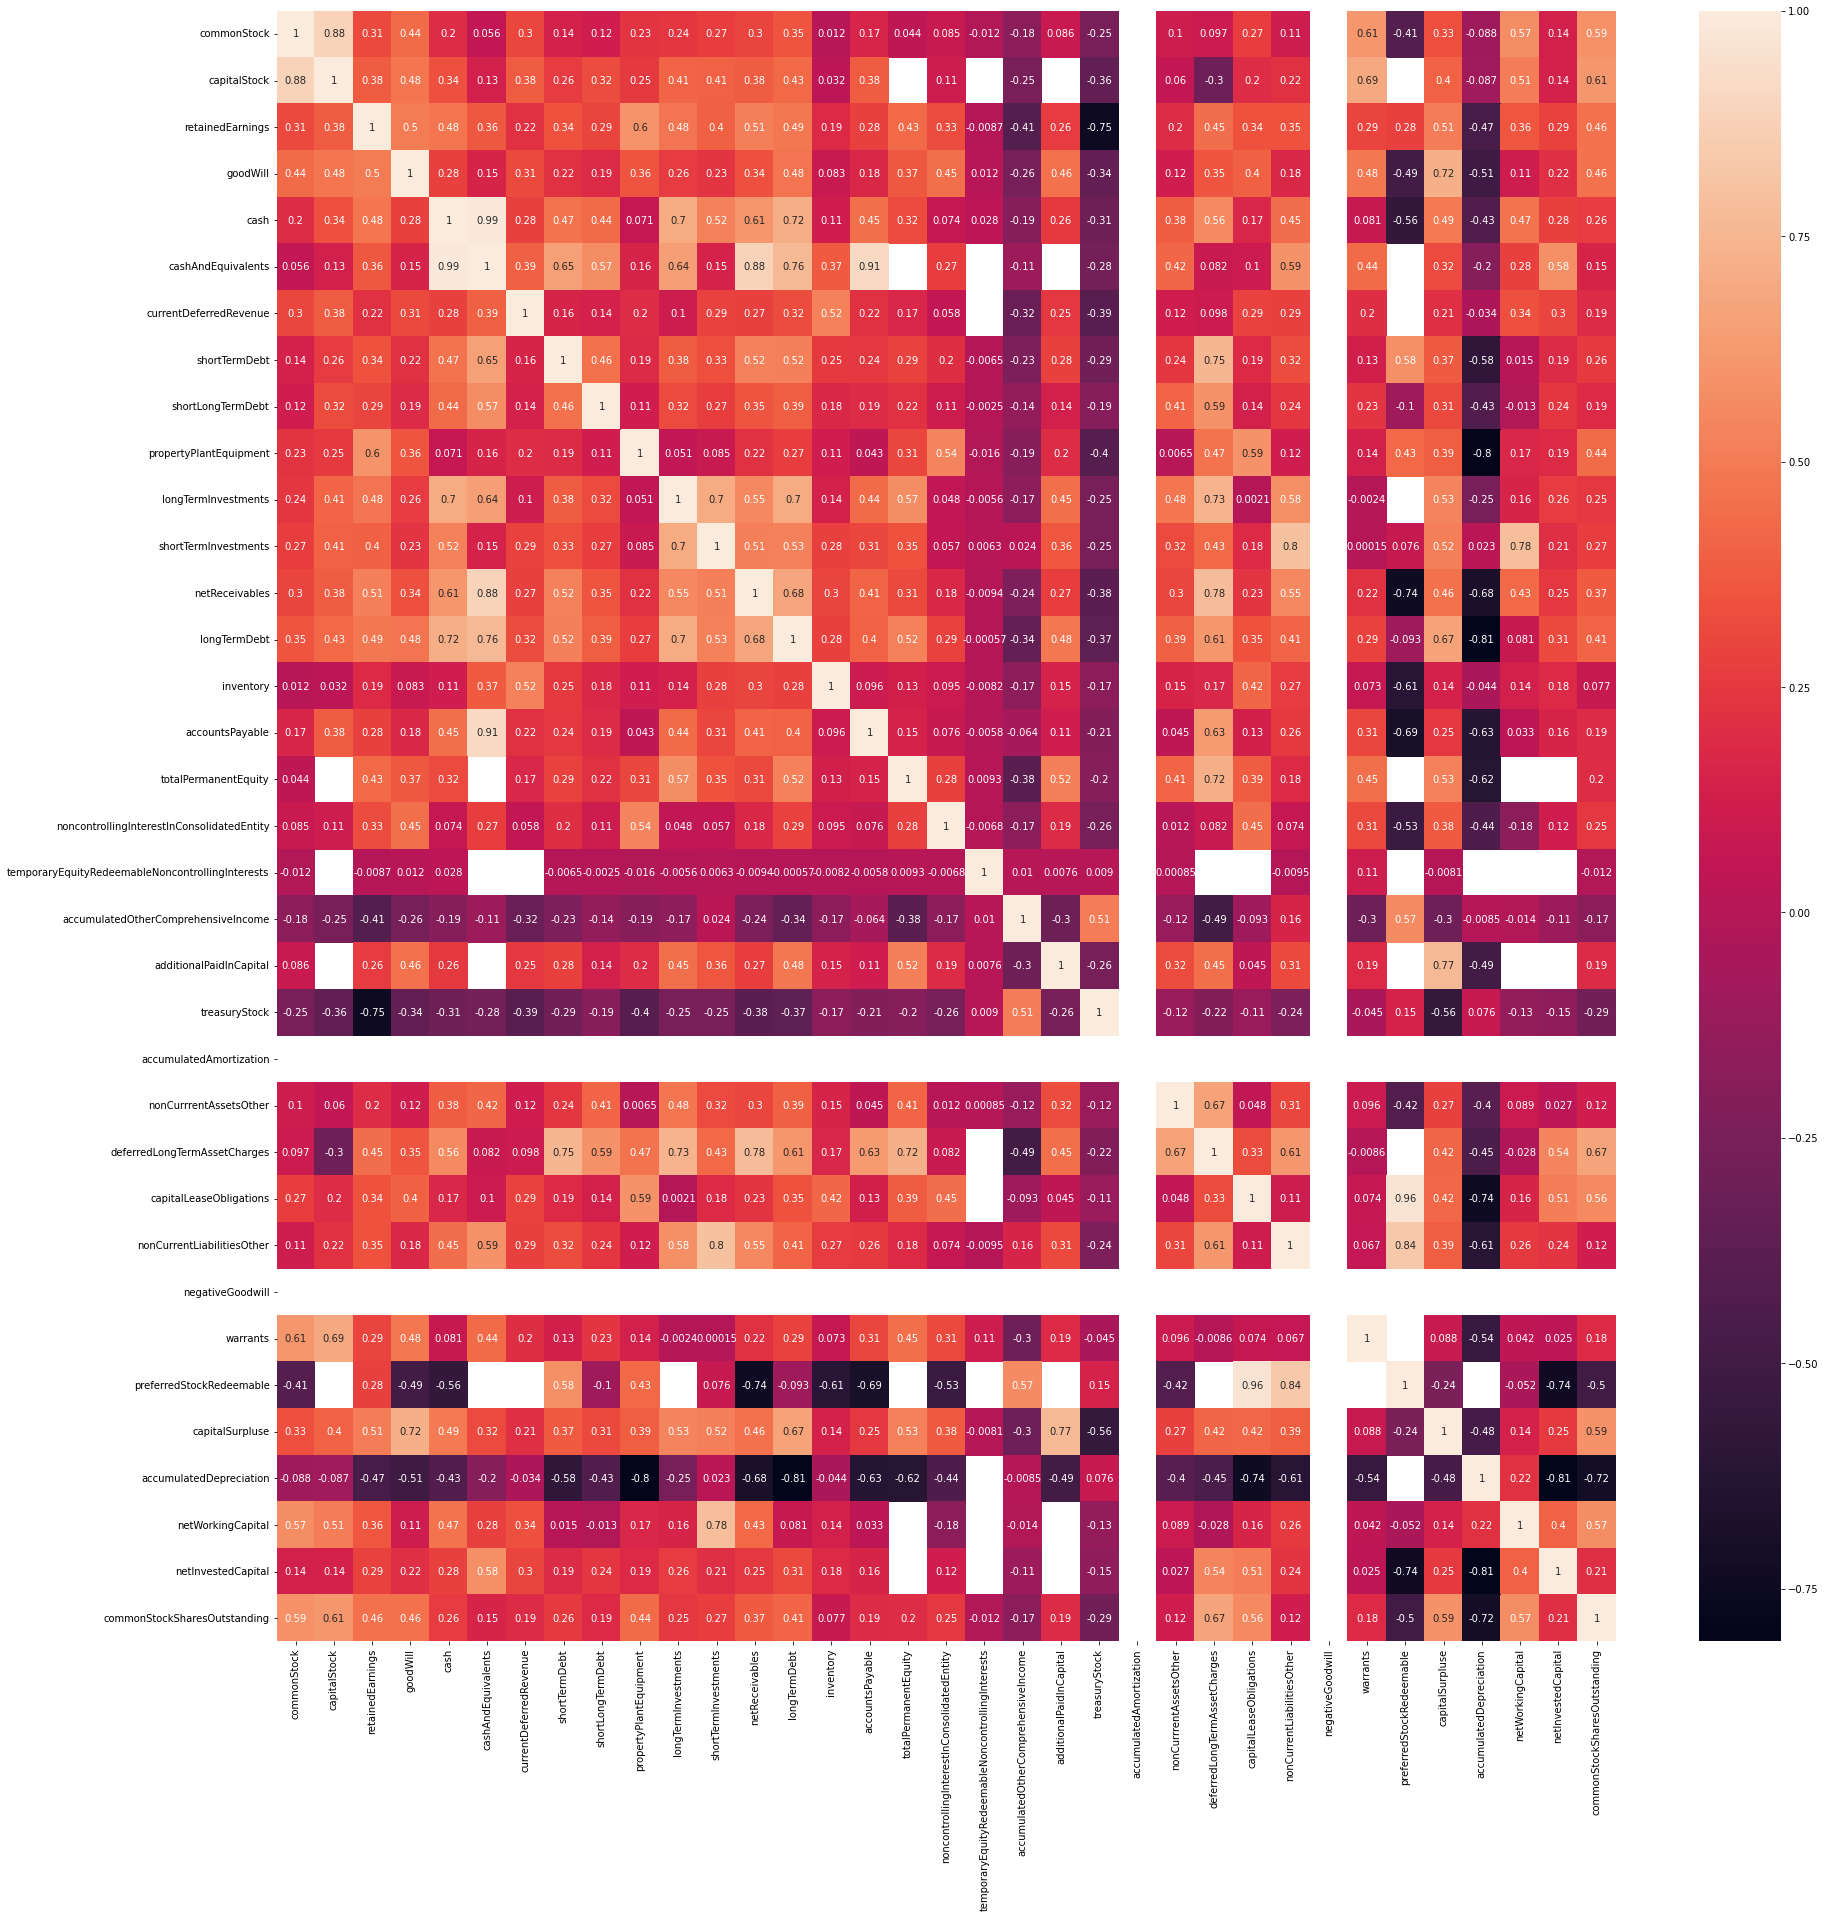

In [26]:
corr_matrix = df_bs.corr()
sns.heatmap(corr_matrix, annot=True)
plt.rcParams["figure.figsize"] = (50, 50)
plt.show()

### Old method

In [ ]:
# Dropping correlated features
threshold = 0.7

corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
to_drop_2 = [column for column in upper.columns if any(upper[column] > threshold)]

# Dropping empty columns
to_drop_2 += ['accumulatedAmortization', 'negativeGoodwill']
print(to_drop_2)

df_bs.drop(columns=to_drop_2, inplace=True)

['capitalStock', 'cashAndEquivalents', 'shortTermInvestments', 'netReceivables', 'longTermDebt', 'accountsPayable', 'treasuryStock', 'deferredLongTermAssetCharges', 'nonCurrentLiabilitiesOther', 'preferredStockRedeemable', 'capitalSurpluse', 'accumulatedDepreciation', 'netWorkingCapital', 'netInvestedCapital', 'commonStockSharesOutstanding', 'accumulatedAmortization', 'negativeGoodwill']


In [ ]:
# Final features
df_bs.columns[4:].to_list()

['commonStock',
 'retainedEarnings',
 'goodWill',
 'cash',
 'currentDeferredRevenue',
 'shortTermDebt',
 'shortLongTermDebt',
 'propertyPlantEquipment',
 'longTermInvestments',
 'inventory',
 'totalPermanentEquity',
 'noncontrollingInterestInConsolidatedEntity',
 'temporaryEquityRedeemableNoncontrollingInterests',
 'accumulatedOtherComprehensiveIncome',
 'additionalPaidInCapital',
 'nonCurrrentAssetsOther',
 'capitalLeaseObligations',
 'warrants']

Features that should be good for univariate ARIMA:
```
'commonStock', 'retainedEarnings', 'goodWill', 'cash', 'currentDeferredRevenue', 'shortTermDebt', 'shortLongTermDebt', 'propertyPlantEquipment', 'longTermInvestments', 'inventory', 'totalPermanentEquity', 'warrants'
```

### Updated method

In [48]:
threshold = 0.7
corr_matrix = df_bs.corr()
corr_matrix_abs = corr_matrix.abs()
mat = np.array(corr_matrix_abs)
corr_matrix_abs["counts"] = [np.sum(item > threshold)-1 for item in mat]

to_drop_2 = corr_matrix_abs[~corr_matrix_abs['counts'].between(0, 3)].index.to_list()

df_bs.drop(columns=to_drop_2, inplace=True)

In [50]:
# Dropping implausible features by hand
to_drop_3 = ['capitalStock', 'shortLongTermDebt', 'totalPermanentEquity',
             'noncontrollingInterestInConsolidatedEntity', 
             'temporaryEquityRedeemableNoncontrollingInterests',
             'accumulatedOtherComprehensiveIncome', 'additionalPaidInCapital',
             'nonCurrrentAssetsOther', 'capitalLeaseObligations',
             'nonCurrentLiabilitiesOther', 'capitalSurpluse',
             'commonStockSharesOutstanding']
df_bs.drop(columns=to_drop_3, inplace=True)

In [53]:
df_bs.columns.to_list()[4:]

['commonStock',
 'retainedEarnings',
 'goodWill',
 'cash',
 'currentDeferredRevenue',
 'shortTermDebt',
 'propertyPlantEquipment',
 'longTermInvestments',
 'shortTermInvestments',
 'netReceivables',
 'longTermDebt',
 'inventory',
 'accountsPayable',
 'treasuryStock',
 'warrants',
 'netWorkingCapital',
 'netInvestedCapital']